## Install nightly version of TensorFlow.


In [7]:
%pip install --upgrade --quiet pip
%pip install --upgrade --quiet tf_nightly-2.0-preview

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.0.0-dev20190820


If you get a version that is from July 31, please make sure to update pip. You need pip version 19.1 or higher.

## Check Keras

This is a simple repro that ensures that the Keras feature columns used in this tutorial will work properly.

In [2]:
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='int32'),
    'b' : tf.keras.layers.Input(name='b', shape=(), dtype='int32')
}

# feature columns based on training inputs
infc = {
    'a' : tf.feature_column.categorical_column_with_identity('a', num_buckets = 7),
    'b' : tf.feature_column.categorical_column_with_identity('b', num_buckets = 24)
}
#infc['ab'] = tf.feature_column.crossed_column([infc['a'], infc['b']], 2 )

# transformed
outfc = {
    'a' : tf.feature_column.indicator_column(infc['a']),
    'b' : tf.feature_column.indicator_column(infc['b']),
    #'ab': tf.feature_column.embedding_column(infc['ab'], 2)                                            
}

# model architecture
ds = tf.keras.layers.DenseFeatures(outfc.values())(inputs)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'a': [3, 5, 2],
    'b': [13, 15, 18]
})
y =  [3.0, 2.0, 2.0]

#shutil.rmtree('04_keras/checkpoints/', ignore_errors=True)
#checkpoint_path = "04_keras/checkpoints/nightly.cpt"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=1)

model.fit([df['a'], df['b']], y, steps_per_epoch=1) #, callbacks=[cp_callback])
model.evaluate([df['a'], df['b']], y)

model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
}, steps=1)

W0820 18:51:59.834915 139633601226496 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4271: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0820 18:51:59.836743 139633601226496 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4326: IdentityCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


2.0.0-dev20190820


W0820 18:51:59.968906 139633601226496 training.py:507] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.series.Series'>"}), <class 'NoneType'>
W0820 18:51:59.970422 139633601226496 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.


Train on 1 samples
1/1 [==============================] - 0s 96ms/step - loss: 5.1734 - mse: 5.1734


W0820 18:52:00.307329 139633601226496 training.py:507] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.series.Series'>"}), <class 'NoneType'>


3/3 [==============================] - 0s 22ms/sample - loss: 5.1600 - mse: 5.1600


array([[0.39770463]], dtype=float32)

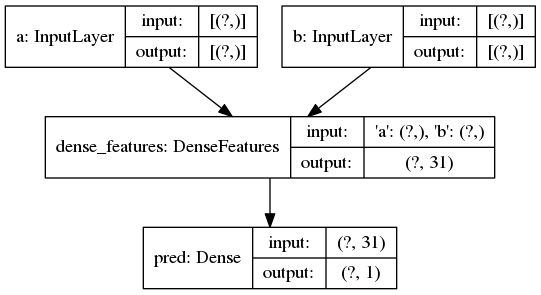

In [3]:
tf.keras.utils.plot_model(model, 'repro_model.png', show_shapes=True)

In [4]:
# demonstrates how to write a custom serving function
class ExportModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__(self)
        self.model = model

    @tf.function(input_signature=[
        tf.TensorSpec([None,], dtype='int32', name='a'),
        tf.TensorSpec([None,], dtype='int32', name='b')
    ])
    def serving_fn(self, a, b):
        return {
            'pred' : self.model({'a': a, 'b': b}) #, steps=1)
        }

    def save(self, export_path):
        sigs = {
            'serving_default' : self.serving_fn
        }
        tf.keras.backend.set_learning_phase(0) # inference only
        tf.saved_model.save(self, export_path, signatures=sigs)

import shutil, os, datetime
OUTPUT_DIR = '04_keras/export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))

# sm = ExportModel(model); sm.save(EXPORT_PATH)  # custom serving function
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

W0820 18:52:09.215143 139633601226496 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_a:0
  inputs['b'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_b:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [6]:
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

04_keras/export/savedmodel/20190820185208
04_keras/export/savedmodel/20190820185208/saved_model.pb
04_keras/export/savedmodel/20190820185208/assets
04_keras/export/savedmodel/20190820185208/variables
04_keras/export/savedmodel/20190820185208/variables/variables.index
04_keras/export/savedmodel/20190820185208/variables/variables.data-00000-of-00001


In [ ]:
%%writefile repro.json
{"a": 3, "b": 13}

In [ ]:
%%bash
PROJECT=cloud-training-demos
BUCKET=${PROJECT}-ml
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=v1

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.14 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

Monitor the model creation at [GCP Console > AI Platform](https://console.cloud.google.com/mlengine/models/taxifare/) and once the model version `v1` is created, proceed to the next cell.

In [ ]:
!gcloud ai-platform predict --model taxifare --json-instances repro.json --version v1

In [ ]:
## REPRO for @tf.function

import tensorflow as tf
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'pickup_datetime' : tf.keras.layers.Input(name='a', shape=(), dtype='string')
}

transformed = {}
feature_columns = {}

# hourofday can be done through a tf.strings.substr and works okay
transformed['hourofday'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
        name='hourofday'
)(inputs['pickup_datetime'])
feature_columns['hourofday'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

# ADDING THIS CODE CAUSES ERROR
if False:
    DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    def get_dayofweek(s):
        if type(s) is not str:
            s = s.numpy().decode('utf-8') # if it is a Tensor
        ts = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")
        return DAYS[ts.weekday()]

    print(get_dayofweek('2012-07-05 14:18:00 UTC'))
    print(get_dayofweek(tf.constant('2012-07-05 14:18:00 UTC')))

    def dayofweek(ts_in):
        return tf.map_fn(
            lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
            ts_in
        )

    transformed['dayofweek'] = tf.keras.layers.Lambda(
            lambda x: dayofweek(x),
            name='dayofweek_pyfun'
    )(inputs['pickup_datetime'])
    transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
    feature_columns['dayofweek'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = DAYS))
## END ADD

# model architecture
ds = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'pickup_datetime': ['2012-07-05 14:18:00 UTC', '2012-07-05 15:18:00 UTC'],
})
y =  [3.0, 2.0]

# need clean checkpoint path: otherwise get cache error
OUTDIR='/tmp'
shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([df['pickup_datetime']], y, steps_per_epoch=1, callbacks=[cp_callback])


import shutil, os, datetime
OUTPUT_DIR = '04_keras/export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH)

In [ ]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

In [ ]:
## repro for "unhashable type list"

import tensorflow as tf
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='float32'),
    'b' : tf.keras.layers.Input(name='b', shape=(), dtype='float32'),
}

if False:
    # Skipping full serialization of object <tensorflow.python.keras.engine.training.Model object at 0x7fe60dbabc50>, because an error occurred while tracing layer functions. Error message: unhashable type: 'list'
    transformed = inputs.copy()
else:
    # no problem if I do this
    transformed = {
        colname : tf.keras.layers.Lambda(lambda x : x, name='passthrough_{}'.format(colname))(inputs[colname])
              for colname in inputs.keys()
    }    

transformed['c'] = tf.keras.layers.Lambda(lambda x: x*x, name='c_sq_b')(inputs['b'])

feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
           for colname in ['a', 'b', 'c']
}

# model architecture
ds = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'a' : [3.0, 4.0],
    'b' : [1.0, 2.0]
})
y =  [3.0, 2.0]

# need clean checkpoint path: otherwise get cache error
OUTDIR='/tmp'
shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([df['a'], df['b']], y, batch_size=1, callbacks=[cp_callback])


import shutil, os, datetime
OUTPUT_DIR = '04_keras/export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH)

!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}